# Record an audio

- Digitalizing audio - [web article](https://www.izotope.com/en/learn/digital-audio-basics-sample-rate-and-bit-depth.html)
- Using from browser accesing microphone, through js - [MediaRecorder](https://developer.mozilla.org/en-US/docs/Web/API/MediaRecorder/MediaRecorder) object

In [1]:
from io import BytesIO
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream, { mimeType: 'audio/ogg;codecs=opus' })
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  print("Speak Now...")
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  return b


In [22]:
audio_bytes=record(5)

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !


In [23]:
with open("audio.opus", "wb") as file:
    file.write(audio_bytes)

import IPython
IPython.display.Audio(audio_bytes)

In [5]:
print(type(audio_bytes),len(audio_bytes))


<class 'bytes'> 77226


In [6]:
audio_bytes[:20]
# OGG format, Opus codec

b'OggS\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\xc3\xaf\x951\x00\x00'

78955 32766 -32768


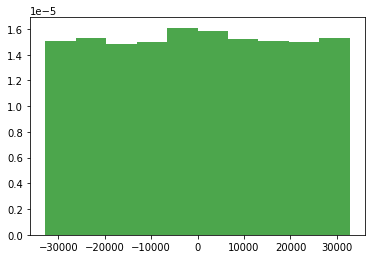

In [ ]:
data_s16 = np.frombuffer(audio_bytes, dtype=np.int16, count=len(audio_bytes)//2, offset=0)
print(len(data_s16),data_s16.max(),data_s16.min())
import matplotlib.pyplot as plt
plt.hist(data_s16, 10, density = 1, color ='green',alpha = 0.7)
plt.show()

# Transcribe audio

- [Whipser](https://github.com/openai/whisper) - open source SOTA ASR

In [7]:
!pip install ffmpeg-python==0.2.0
!pip install git+https://github.com/openai/whisper.git 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-9na51rxr
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-9na51rxr
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 33.8 MB/s 
     |████████████████████████████████| 182 kB 42.9 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175239 sha256=11824529e48fd40e99678cd28d45118ed0a08a8ecbe5c2a5187c9b3f76e41bcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-5hfwwq9s/wheels/16/15/89/1c7bb31bd0006793a95549d04785121a8a36daad9158e1e43a
Successfully built whisper


In [8]:
import numpy as np
import whisper

In [25]:
model = whisper.load_model("small")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)
#model = whisper.load_model("small")


100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 112MiB/s]


Model is multilingual and has 240,582,912 parameters.


In [26]:
result = model.transcribe("audio.opus", language='hu')

print(f"Language: {result['language']}")
print(f"Number of segments: {len(result['segments'])}")
print(result['text'])

/usr/local/lib/python3.7/dist-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Language: hu
Number of segments: 1
 Tervuszt kedves barátom, hogy vagy egyszerű mondat.


In [ ]:
print(result['text'])

 Heló, Egyrenek hívnak és a kedvenc ételem a pizza.




```
`# This is formatted as code`
```

# Translate audio

- Whipser [DecodingOptions github link](https://github.com/openai/whisper/blob/76148a56c56d4a5869335d5b5b478c293d4d1910/whisper/decoding.py#L72)

In [27]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("audio.opus")
audio = whisper.pad_or_trim(audio)
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# decode the audio
options = whisper.DecodingOptions(language='hu',task='translate',fp16=False)
result_translate = whisper.decode(model, mel, options)

print(result_translate.text)

My dear friend, how are you? I'm good.
